In [1]:
from pydrake.all import (MathematicalProgram, Solve, MonomialBasis,
                         DiagramBuilder, Evaluate, LogVectorOutput, Simulator,
                         SymbolicVectorSystem, Variable, ToLatex, Polynomial,
                         VectorSystem, eq, ge, le, Formula, Expression, Evaluate,
                         LeafSystem, AbstractValue,
                         )

from IPython.display import clear_output

import os
import copy
import time
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from dataclasses import dataclass
from dccm_quasistatic.utils.math_utils import (create_square_symmetric_matrix_from_lower_tri_array,
                                               get_n_lower_tri_from_matrix_dim,
                                               matrix_inverse)
from dccm_quasistatic.utils.sample_generator import (SampleGenerator, SampleGeneratorParams)
from dccm_quasistatic.controller.dccm_params import DCCMParams


from qsim.parser import (
    QuasistaticParser,
    QuasistaticSystemBackend,
    GradientMode,
)

from qsim.simulator import ForwardDynamicsMode, InternalVisualizationType
from qsim.model_paths import models_dir

/home/shaoyuan/Documents/Software/quasistatic_simulator/robotics_utilities/qp_derivatives/qp_derivatives.py:2: DrakeDeprecationWarning: Please import from the pydrake.solvers module directly, instead of the deprecated pydrake.solvers.mathematicalprogram submodule. The deprecated code will be removed from Drake on or after 2023-05-01.
  import pydrake.solvers.mathematicalprogram as mp


In [2]:
class DCCMSystem():
    def __init__(self, params: DCCMParams):
        self._params = params
        self._wijc = None
        self._lijc = None
        
    def control_law(self, xk: np.array, xd: np.array, ud: np.array, t: float = 0):
        
        assert (self._wijc is not None) and (self._lijc is not None), "DCCM has not been calculated"
        print(f"Calculating geodesic at time: {t}, xk = {xk}, xd = {xd}, ud = {ud}")
        start_time = time.time()
        succeeded, xi, delta_xs, delta_s, geodesic = self.calculate_geodesic(xd, xk)
        if not succeeded:
            print(f"Geodesic calculation failed at time: {t}, u = {ud}")
            return ud, geodesic, succeeded
    
        x = [Variable(f"x_{i}") for i in range(self._params.dim_x)]
        v = [monomial.ToExpression() for monomial in MonomialBasis(x, self._params.deg)] # might need to wrap x in Variables()

        # Probably need to set this u* to something else!
        u = ud
        for i in range(self._params.n_geodesic_segments):
            # Create mapping of variables to values
            env = dict(zip(x, xi[i]))
            # Substitute xi into v(xi)
            v_xi = Evaluate(v, env).flatten()
            # Construct L(xi)
            Li_elements = self._lijc.dot(v_xi)
            Li = Li_elements.reshape(self._params.dim_u, self._params.dim_x)
            # Construct W(xi)
            Wi_lower_tri = self._wijc.dot(v_xi)
            # print(f"Wk_lower_tri.shape: {Wk_lower_tri.shape}")

            Wi = create_square_symmetric_matrix_from_lower_tri_array(Wi_lower_tri)
            # Get M(xi) by inverting W(xi)
            Mi = np.linalg.inv(Wi)
            # Add marginal control input to u
            u = u + delta_s[i] * Li @ Mi @ delta_xs[i]
        
        print(f"Geodesic calculation succeeded at time: {t}, u = {u}, calculation took {time.time() - start_time} seconds")

        return u, geodesic, succeeded

    def calculate_geodesic(self, x0, x1):
        """
        Calculate the geodesic from x0 to x1.
        Based on optimization (27)
        Args:
            x0: (dim_x,): initial state, will correspond to x_k
            x1: (dim_x,): final state, will correspond to x*_k
        """
        print("calculate_geodesic initialize")
        start_time = time.time()
        prog = MathematicalProgram()
        
        # Numerical state evaluation along the geodesic
        x = prog.NewContinuousVariables(self._params.n_geodesic_segments + 1, self._params.dim_x, 'x')

        # For getting around inverting W(x_i)
        # m = prog.NewContinuousVariables(self._params.n_geodesic_segments, self._params.dim_x * self._params.dim_x, 'm')

        # For optimizing over the epigraph instead of the original objective
        y = prog.NewContinuousVariables(self._params.n_geodesic_segments, 'y')

        # Displacement vector discretized wrt s parameter
        delta_xs = prog.NewContinuousVariables(self._params.n_geodesic_segments, self._params.dim_x, '\delta x_s')
        
        # Small positive scaler value
        delta_s = prog.NewContinuousVariables(self._params.n_geodesic_segments, 's')

        # Add constraint: make sure delta_s's are positive
        si_positive = prog.AddLinearConstraint(ge(delta_s, np.ones_like(delta_s) * 1e-6))

        # Add constraints
        # Constraint 1
        si_sum_to_one = prog.AddLinearConstraint(sum(delta_s) == 1)
        discrete_distances_sum = x0
        # Constraint: Initial state matches x0
        prog.AddConstraint(eq(x[0], x0))
        for i in range(self._params.n_geodesic_segments):
            discrete_distances_sum = discrete_distances_sum + delta_s[i] * delta_xs[i]
            # Constraint 2: Intermediate state matches sum of deltas

            prog.AddConstraint(eq(x[i+1], discrete_distances_sum))
        # Constraint 3
        total_distances_match = prog.AddConstraint(eq(discrete_distances_sum, x1))
        # Sum cost over all segments
        prog.AddCost(np.sum(y))
        # Constraints for the values of y
        
        for i in range(self._params.n_geodesic_segments):
            v = [monomial.ToExpression() for monomial in MonomialBasis(x[i], self._params.deg)]
            # Construct W(x_i)
            Wk_lower_tri = self._wijc.dot(v)
            Wi = create_square_symmetric_matrix_from_lower_tri_array(Wk_lower_tri)

            Mi = matrix_inverse(Wi) # <= because of the division, this is not a polynomial anymore.
            # Mi = m[i].reshape(self._params.dim_x, self._params.dim_x) 
            # MiWi = Mi @ Wi
            # WiMi = Wi @ Mi
            # for j in range(self._params.dim_x):
            #     for k in range(self._params.dim_x):
            #         if j == k:
            #             prog.AddConstraint(MiWi[j, k] == 1)
            #             # prog.AddConstraint(WiMi[j, k] == 1)
            #         else:
            #             prog.AddConstraint(MiWi[j, k] == 0)
            #             # prog.AddConstraint(WiMi[j, k] == 0)
            metric_dist = delta_s[i] * delta_xs[i].T @ Mi @ delta_xs[i]
            # print(f"metric_dist: {metric_dist}")
            # print(f"metric_dist.is_polynomial(): {metric_dist.is_polynomial()}")
            # print(f"metric_dist type: {type(metric_dist)}")
            y_constraint = prog.AddConstraint(metric_dist <= y[i])
            # prog.AddConstraint(metric_dist >= 0)
            
            y_constraint.evaluator().set_description(f"y_constraint_{i}")
            
        
        # Try to keep delta_s small
        prog.AddCost(np.sum(delta_s**2))

        # Seed initial guess as all 1's so that determinant will not be 0 and cause a failure
        prog.SetInitialGuessForAllVariables(np.ones(prog.num_vars()))
        prog.SetInitialGuess(delta_s, np.ones_like(delta_s) * 1 / self._params.n_geodesic_segments)
        evenly_spaced_delta = (x1 - x0) / self._params.n_geodesic_segments
        for i in range (self._params.n_geodesic_segments):
            prog.SetInitialGuess(delta_xs[i],  i * evenly_spaced_delta)
            prog.SetInitialGuess(x[i], x0 + i * evenly_spaced_delta)
        print("Start solving geodesic, time taken to setup: ", time.time() - start_time, " seconds")
        start_time = time.time()
        result = Solve(prog)
        print("Solver succeeded: ", result.is_success(), " in ", time.time() - start_time, " seconds")

        # infeasible_constraints = result.GetInfeasibleConstraints(prog)
        # for c in infeasible_constraints:
        #     print(f"infeasible constraint: {c}")

        geodesic_length = np.sum(result.GetSolution(y))
        return result.is_success(), result.GetSolution(x), result.GetSolution(delta_xs), result.GetSolution(delta_s), geodesic_length
    
    def calculate_dccm_from_samples(self, x_samples, u_samples, x_next_samples, A_samples, B_samples) -> None:
        n_dccm_samples = len(x_samples)
        start_time = time.time()
        print(f"Calculating DCCM from {n_dccm_samples} samples")
        prog = MathematicalProgram()
        # Indeterminates
        x = prog.NewIndeterminates(self._params.dim_x, 'x_{k}')
        u = prog.NewIndeterminates(self._params.dim_u, 'u_{k}')
        w = prog.NewIndeterminates(self._params.dim_x * 2, 'w')
        w = np.array(w).reshape(-1, 1)

        # Monomial basis
        v = [monomial.ToExpression() for monomial in MonomialBasis(x, self._params.deg)]
        dim_v = len(v)
        # print(f"dim_v: {dim_v}")
        n_lower_tri = get_n_lower_tri_from_matrix_dim(self._params.dim_x)
        wijc = prog.NewContinuousVariables(rows=n_lower_tri, cols=dim_v, name='wijc')
        
        # print("wijc: ", wijc.shape)

        lijc = prog.NewContinuousVariables(rows=self._params.dim_x * self._params.dim_u, cols=dim_v, name='lijc')

        r = prog.NewContinuousVariables(1, 'r')

        for i in range(n_dccm_samples):
            xi = x_samples[i]
            ui = u_samples[i]
            # A and B matrices
            Ak = A_samples[i]
            Bk = B_samples[i]

            # Create mapping of variables to values
            env = dict(zip(x, xi))
            # Substitute xi into v(xi)
            v_xi = Evaluate(v, env).flatten()

            xi_next = x_next_samples[i]
            # Create mapping of variables to values
            env = dict(zip(x, xi_next))
            # Substitute xi_next into v(xi_next)
            v_xi_next = Evaluate(v, env).flatten()
            # print(f"v_xi.shape: {v_xi.shape}")

            Wk_lower_tri = wijc.dot(v_xi)
            # print(f"Wk_lower_tri.shape: {Wk_lower_tri.shape}")

            Wk = create_square_symmetric_matrix_from_lower_tri_array(Wk_lower_tri)
            # Wk has shape (dim_x, dim_x)

            Wk_next_lower_tri = wijc.dot(v_xi_next)
            Wk_next = create_square_symmetric_matrix_from_lower_tri_array(Wk_next_lower_tri)


            Lk_elements = lijc.dot(v_xi)
            Lk = Lk_elements.reshape(self._params.dim_u, self._params.dim_x)

            # print("Wk: ", Wk.shape)
            # print("Wk_next: ", Wk_next.shape)
            # print("Ak: ", Ak.shape)
            # print("Bk: ", Bk.shape)
            # print("Lk: ", Lk.shape)

            print("Adding constraint for sample ", i)
            clear_output(wait=True)
            cross_diag = Ak @ Wk + Bk @ Lk
            omega = np.block([[Wk_next, cross_diag],
                            [cross_diag.T, (1-self._params.beta)*Wk]])
            # print("omega: ", omega.shape)
            # Note: w is an additional indeterminate that enforces that omega is PSD

            prog.AddSosConstraint((w.T @ omega @ w - r[0] * w.T @  w).flatten()[0])
            

        prog.AddLinearCost(r[0])
        prog.AddLinearConstraint(r[0] >= 0.01)

        print("Start solving DCCM")
        result = Solve(prog)
        print("Solver succeeded: ", result.is_success(), " in ", time.time() - start_time, " seconds")

        infeasible_constraints = result.GetInfeasibleConstraints(prog)
        for c in infeasible_constraints:
            print(f"infeasible constraint: {c}")

        # Extract the solution
        self._wijc = result.GetSolution(wijc)
        self._lijc = result.GetSolution(lijc)
        print("wijc:\n", self._wijc)
        print("\nlijc:\n", self._lijc)
        print("r:\n", result.GetSolution(r))
        return result.is_success()    

In [3]:
sample_generator_params = SampleGeneratorParams(
    log_barrier_weight=10,
    n_samples=500,
    workspace_radius=1,
    actuated_collision_geomtery_names=["hand::collision"]
)

dccm_params = DCCMParams(
    time_step=None,
    pid_gains=None,
    robot_urdf_path=None,
    dim_x=3,
    dim_u=2,
    deg=3,
    beta=0.5,
    n_geodesic_segments=1,
)
q = np.array([-1.5, 0, 0.5]) # [object_x, robot_x]

q_model_path = os.path.join(models_dir, "q_sys", "three_spheres_y.yml")
q_parser = QuasistaticParser(q_model_path)
q_sim = q_parser.make_simulator_cpp()
q_sim_py = q_parser.make_simulator_py(InternalVisualizationType.Cpp)

q_sim_py.update_mbp_positions_from_vector(q)
q_sim_py.draw_current_configuration()

file_prefix = "saved_dccm_coeffs/three_sphere_"
base_filename = f"samples{sample_generator_params.n_samples}_lbw{sample_generator_params.log_barrier_weight}_wr{sample_generator_params.workspace_radius}_deg{dccm_params.deg}.npy"

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [4]:
# sample_generator = SampleGenerator(sample_generator_params, q_sim=q_sim, q_sim_py=q_sim_py, parser=q_parser)
# samples = sample_generator.generate_three_spheres_samples(visualize=False)

# dccm_system = DCCMSystem(dccm_params)
# success = dccm_system.calculate_dccm_from_samples(*samples)
# if success:
#     np.save(f"{file_prefix}wijc_{base_filename}", dccm_system._wijc)
#     np.save(f"{file_prefix}lijc_{base_filename}", dccm_system._lijc)


In [5]:
dccm_system = DCCMSystem(dccm_params)
# Load the DCCM from file
dccm_system._wijc = np.load(f"{file_prefix}wijc_{base_filename}")
dccm_system._lijc = np.load(f"{file_prefix}lijc_{base_filename}")

print(f"wijc:\n{dccm_system._wijc}")
print(f"lijc:\n{dccm_system._lijc}")

wijc:
[[ 6.09016445e+00  1.68112256e+03  1.74690312e+02  6.12572645e+02
   2.77647577e+02 -2.88416506e+03 -2.29688269e+03  8.20896368e+02
   2.28596231e+03 -2.74220229e+02  1.64015591e+03 -2.72593845e+03
   2.15564462e+03 -1.99859712e+03 -1.40028608e+03  1.50127139e+03
  -1.93512647e+03  2.22845554e+03  4.80336555e+01  8.23897135e+02]
 [ 3.62579328e+03 -6.62528887e+04 -1.81977028e+05 -3.18682095e+04
   7.10284369e+04  4.64440756e+05  1.31416348e+05 -2.95832072e+05
  -2.06152445e+05  1.02969692e+05 -3.15333792e+04 -6.05646677e+04
   1.85464998e+04  9.07526928e+04 -8.44015043e+04  6.12059514e+04
   7.22604789e+03  1.05855760e+04 -2.77208956e+04 -5.90442620e+02]
 [-8.86791598e+05 -4.37844278e+06  2.45692747e+06  5.11814781e+06
   2.86983065e+06 -6.14964718e+06  1.30142873e+06  5.99505575e+06
  -3.38804600e+06 -4.23245453e+06 -1.49335360e+06  4.63263101e+06
   7.64851364e+06 -2.96692354e+06 -3.45288873e+06 -7.24213970e+04
   1.88500502e+06  1.33345554e+06  5.53022848e+04  1.32750098e+06]
 

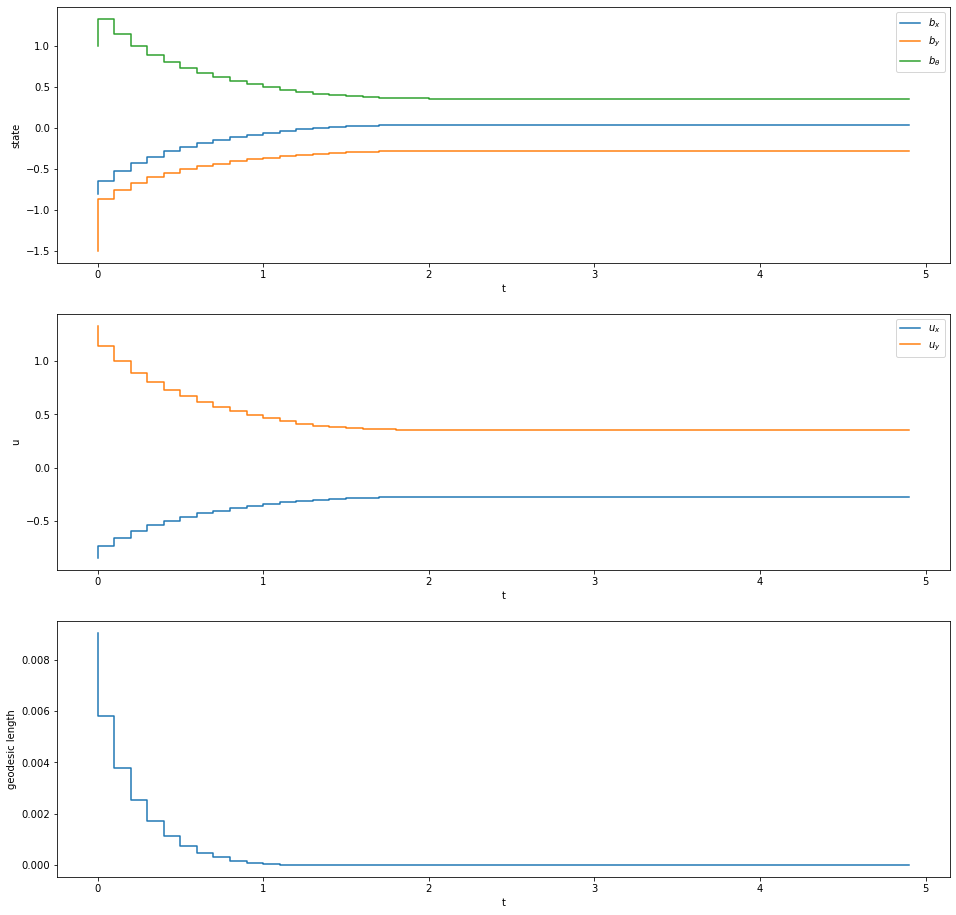

t: [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3000000000000003, 2.4000000000000004, 2.5, 2.6, 2.7, 2.8000000000000003, 2.9000000000000004, 3.0, 3.1, 3.2, 3.3000000000000003, 3.4000000000000004, 3.5, 3.6, 3.7, 3.8000000000000003, 3.9000000000000004, 4.0, 4.1000000000000005, 4.2, 4.3, 4.4, 4.5, 4.6000000000000005, 4.7, 4.800000000000001, 4.9], 
q: [array([-0.8, -1.5,  1. ]), array([-0.6388993 , -0.86338439,  1.33286227]), array([-0.51708294, -0.74919833,  1.14575471]), array([-0.42247694, -0.66332671,  1.00375626]), array([-0.34669125, -0.59689891,  0.89350026]), array([-0.28419492, -0.54389586,  0.80520288]), array([-0.23141449, -0.50034288,  0.73241551]), array([-0.18600478, -0.46367693,  0.67097334]), array([-0.14648868, -0.43221142,  0.61814463]), array([-0.11180201, -0.40489931,  0.5722109 ]), array([-0.0

In [6]:
total_duration_s = 5

q = np.array([-0.8, -1.5, 1]) # [box_x, box_y, box_theta, sphere_x, sphere_y]
q_desired = np.array([0, -0.3, 0.5]) # [box_x, box_y, box_theta, sphere_x, sphere_y]

q_sim_py.update_mbp_positions_from_vector(q)
q_sim_py.draw_current_configuration()


sim_p = copy.deepcopy(q_sim.get_sim_params())
sim_p.h = 0.1
sim_p.unactuated_mass_scale = 10
# exact dynamics
# sim_p.gradient_mode = GradientMode.kNone
# sim_p.forward_mode = ForwardDynamicsMode.kQpMp
# Smoothed dynamics
sim_p.gradient_mode = GradientMode.kAB
sim_p.log_barrier_weight = sample_generator_params.log_barrier_weight
sim_p.forward_mode = ForwardDynamicsMode.kLogIcecream

n_steps = int(total_duration_s / sim_p.h)
t_log = []
q_log = []
u_log = []
geodesic_log = []
success_log = []

def draw_plot(t, q, u, geodesic):
    clear_output(wait=True)
    fig, axs = plt.subplots(3, 1, figsize=(16, 16))

    axis = axs[0]
    axis.step(t,
            q)
    axis.legend([r'$b_x$', r'$b_y$', r'$b_\theta$', r'$f_x$', r'$f_y$'])
    axis.set_ylabel('state')
    axis.set_xlabel('t')

    axis = axs[1]
    axis.step(t,
            u)
    axis.legend([r'$u_{x}$',r'$u_{y}$'])
    axis.set_ylabel('u')
    axis.set_xlabel('t')

    axis = axs[2]
    axis.step(t,
            geodesic)
    axis.set_ylabel('geodesic length')
    axis.set_xlabel('t')

    plt.show()


for i in range(n_steps):
    t=i*sim_p.h
    t_log.append(t)
    q_log.append(q)
    
    u, geodesic, success = dccm_system.control_law(q,q_desired,q_desired[-2:], t)
    q = q_sim.calc_dynamics(q, u, sim_p)
    q_sim_py.update_mbp_positions_from_vector(q)
    q_sim_py.draw_current_configuration()
    u_log.append(u)
    geodesic_log.append(geodesic)
    success_log.append(success)
    draw_plot(t_log, q_log, u_log, geodesic_log)
    print(f"t: {t_log}, \nq: {q_log}, \nu: {u_log}, \ngeodesic: {geodesic_log}, \nsuccess: {success_log}")

